# Fake News Detection

Nepnieuws is misleidende en onjuiste informatie, die wordt verspreid om vooral geld te verdienen of om publieke opinie te beïnvloeden. Veel websites en social media accounts staan vol met berichten die soms totaal bij elkaar verzonnen zijn of die deels niet waar zijn. Bij het lezen van deze berichten zou je je kunnen afvragen in hoeverre het waar is. Iedereen kan in een nepbericht trappen. "De gevolgen ervan kunnen groot zijn. Fake Berichten hebben zo bijvoorbeeld de mogelijkheid om verkiezingen te beïnvloeden. Aangezien deze heel snel verspreid kunnen worden, is het ook gemakkelijk om de publieke opinie te beïnvloeden. 

Het is dus handig om nepnieuws te herkennen. Alleen vindt niet iedereen dit even makkelijk. Wat nou als je binnen één klik kunt weten of iets nep nieuws is? Dat is dus de doel van dit verslag. 

Met behulp van een aantal ML classifiers en een simpele neurale netwerk wordt er bepaald of een bericht fakeniews is of niet. Er worden drie verschillende modellen getrained: Logistic Regression, Naive Bayes en een neurale netwerk. Een subdoel is om te bepalen wat het verschil nou is tussen deze modellen en welke het best geschikt is voor dit probleem.

### Analyse Probleem

**Wat is het probleem? Wat voor labels heb je?**

We willen voorspellen of een artikel echt of nep is d.m.v. machine learning modellen. Er is een lbinaire abel beschikbaar 0/1 om te bepalen of iets fake nieuws is.

**Dimensies dataset**
- Real news: (21417, 4)
- Fake news: (23481, 4)

**Soorten data/features**
 - titel
 - tekst
 - datum
 - onderwerp artikel

 Alles is van het type object (string)

### Voorspelling

**Welke classifier zal het beste zijn en waarom?**

Ik denk dat Naive Bayes het beste zal doen. Naive Bayes kan namelijk goed werken met tekst data.

**Welke hyperparameters zijn relevant en waarom?** //TODO

### Methoden

**Welke preprocessing stappen zijn nodig?**
- label toevoegen met echt of nep
- twee dataframes aan elkaar toevoegen
- controleren of er lege waardes zijn
- woorden stemmen (gelopen -> loop)
- text veranderen naar een list met zinnen
- stopwoorden verwijderen (woorden die vaak voorkomen en niet zoveel betekenen)
- bekijken of er urls in tekst zitten en deze veranderen naar URL o.i.d.

**Welke classifiers ga je vergelijken? (Minimaal 2 per dataset)**
- Naive Bayes
- Logistic Regression
- LSTM Neural Network

**Welke performance metric is passend?**

Accuracy score

### Bronnen
- https://www.analyticsvidhya.com/blog/2021/01/gaussian-naive-bayes-with-hyperpameter-tuning/


### Importeer libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')


##### Load data

In [2]:
real = pd.read_csv('True.csv')
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [3]:
fake = pd.read_csv('Fake.csv')
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


<mark>Insights<mark>

- Er zijn 4 kolommen
- Alle kolommen zien eruit als strings
- Er zijn geen labels
- De kolommen van de ene dataset komen overeen met de kolommen van de ander

### Analyse probleem

**Wat is het probleem?**

We willen voorspellen of een bericht echt of nepnieuws is d.m.v. een aantal Machine learning modellen.

<br>

**Wat voor label heb je?**

Er zij nnog geen labels beschikbaar. Bij het combineren van de twee datasets moet er een label worden aangemaakt met fake news. De neppe artikelen krijgen de waarde 0 en de anderen een 1.

<br>

**Dimensie dataset**

In [4]:
real.shape, fake.shape

((21417, 4), (23481, 4))

**Soorten data/features**

In [5]:
real.dtypes, fake.dtypes

(title      object
 text       object
 subject    object
 date       object
 dtype: object,
 title      object
 text       object
 subject    object
 date       object
 dtype: object)

<mark>Insights<mark>

- De datasets bevatten zo'n 22000 rijen each.
- Beide datasets bevatten twee kolommen
- De types van de kolommen zijn allemaal hetzelfde

In [6]:
real.describe().T

,count,unique,top,freq
title,21417,20826,Factbox: Trump fills top jobs for his administ...,14
text,21417,21192,(Reuters) - Highlights for U.S. President Dona...,8
subject,21417,2,politicsNews,11272
date,21417,716,"December 20, 2017",182


In [7]:
fake.describe().T

,count,unique,top,freq
title,23481,17903,MEDIA IGNORES Time That Bill Clinton FIRED His...,6
text,23481,17455,,626
subject,23481,6,News,9050
date,23481,1681,"May 10, 2017",46


<mark>Insights<mark>
- Real dataset bestaat uit 21417 rijen, terwijl de Fake dataset uit 23481 rijen bestaat.
- Alle waardes zijn objecten (strings)
- Aantal unieke subjects in Real dataset is twee, terwijl de Fake dataset zes verschillende subjects bevat

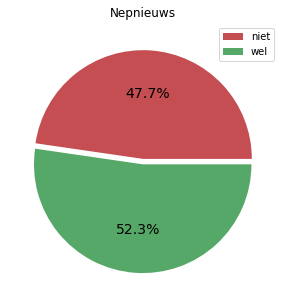

In [8]:
amount_of_rows_real = real.shape[0]
amount_of_rows_fake = fake.shape[0]

#define Seaborn color palette to use
colors = sns.color_palette('deep')[3 : 1 : -1]

# Bekijk of labels wel verdeeld zijn. Niet dat 90% van de data wel borstkanker heeft en maar 10% niet o.i.d. Je kunt dus zien dat het 
# 40/60 verdeeld is. Dat is nog prima.
plt.figure(figsize=(5,5))
plt.pie([amount_of_rows_real, amount_of_rows_fake], colors=colors, autopct='%.1F%%', textprops = {'fontsize':14}, explode = [0,0.05])
plt.legend(labels=['niet','wel'])
plt.title('Nepnieuws')
plt.show()

<mark>Insights<mark>

- Er zijn iets meer berichten dat nepnieuws zijn
- Redelijk in balans

### Voorspelling

**Welke classifier zal het beste zijn en waarom?**

Ik denk dat Naive Bayes het best zal werken, omdat er wordt gewerkt met tekst als data. Naive Bayes kan hier namelijk goed mee werken.

<br>

**Welke hyperparameters zijn relevant en waarom?**

//TODO

<br>

### Methoden

**Welke pre-processing stappen zijn nodig?**

- label toevoegen aan de datasets met real/fake (0/1)
- datasets bij elkaar voegen
- checken of er lege velden of NaN-waardes zijn
- bekijken of wel alle kolommen nodig zijn (hoogstwaarschijnlijk is text al goed genoeg)
- Text processing:
    1. tekst -> kleine letters
    2. als er urls inzitten, eruit halen/ wijzigen naar URL
    3. extra spaties eruit halen
    4. woorden in een tekst naar de stam brengen
    5. tellen hoevaak een woord voorkomt in alle teksten

<br>

**Welke classifiers ga je vergelijken?**

- Logistic Regression
- Naive Bayes
- Support Vector Machine

**Welke performance metric is passend?**

Accuracy score

#### Label toevoegen

<br>Maak de labels aan. Geef nepnieuws aan met 1 en de rest met 0.

In [9]:
real['fake_news'] = 0
fake['fake_news'] = 1

Voeg de twee datasets bij elkaar toe tot een gehaal dataset.

#### Datasets aan elkaar toevoegen

In [10]:
data = pd.concat([real, fake], ignore_index=True)

data

,title,text,subject,date,fake_news
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",1
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",1
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",1
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",1


#### Lege cellen / duplicates check

In [11]:
data.isna().sum()

title        0
text         0
subject      0
date         0
fake_news    0
dtype: int64

In [12]:
data.duplicated().sum()

209

In [13]:
data.drop_duplicates(inplace=True)

<mark>Insights<mark>

- In beide datasets zijn er geen lege waardes
- de dataset bevat 209 duplicated waardes

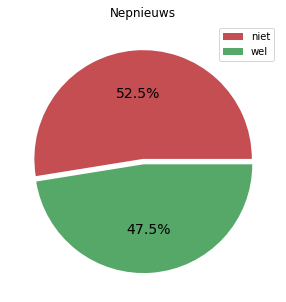

In [14]:
amount_of_rows_real = data[data['fake_news'] == 1]['fake_news'].count()
amount_of_rows_fake = data[data['fake_news'] == 0]['fake_news'].count()

#define Seaborn color palette to use
colors = sns.color_palette('deep')[3 : 1 : -1]

# Bekijk of labels wel verdeeld zijn.
plt.figure(figsize=(5,5))
plt.pie([amount_of_rows_real, amount_of_rows_fake], colors=colors, autopct='%.1F%%', textprops = {'fontsize':14}, explode = [0,0.05])
plt.legend(labels=['niet','wel'])
plt.title('Nepnieuws')
plt.show()

**Insights**
- de datasets zijn in balas (inclusief duplications).
- verdeling van 52% fake - 48% real

Zet de text en title kolom aan elkaar. Titel is ook immers een deel van de tekst.

In [15]:
data["text"] = data['title'] + data['text']

data['text'][0]

'As U.S. budget fight looms, Republicans flip their fiscal scriptWASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-

Verwijder kolommen die we niet nodig hebben

In [16]:
data.drop(columns=['date', 'title'], axis=1, inplace=True)

data

,text,subject,fake_news
0,"As U.S. budget fight looms, Republicans flip t...",politicsNews,0
1,U.S. military to accept transgender recruits o...,politicsNews,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,politicsNews,0
3,FBI Russia probe helped by Australian diplomat...,politicsNews,0
4,Trump wants Postal Service to charge 'much mor...,politicsNews,0
...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,Middle-east,1
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,Middle-east,1
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Middle-east,1
44896,How to Blow $700 Million: Al Jazeera America F...,Middle-east,1


Nu zijn de twee datasets letterlijk onder elkaar geplakt. Voor het trainen van modellen lijkt het me handig als de data door elkaar heen is. 

In [17]:
data = data.sample(frac=1)

data

,text,subject,fake_news
8488,U.S. House Democratic leader blames Russians f...,politicsNews,0
28240,Buffalo Bills Coach Gives Donald Trump The We...,News,1
604,Senate quickens pace of approving Trump judici...,politicsNews,0
14794,Plane crash in Russia's far east kills six: re...,worldnews,0
8551,Trump campaign asks Capitol Hill to back him i...,politicsNews,0
...,...,...,...
32034,PRESIDENT TRUMP AND FIRST LADY Visit Rep. Stev...,politics,1
3784,"Tillerson: Trump did not discuss 'sources, met...",politicsNews,0
40408,KELLYANNE CONWAY Tells “Haters” Reason She Loo...,left-news,1
3427,"Day before Comey appearance, U.S. intel chiefs...",politicsNews,0


#### Text pre-processing

In [18]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

download nltk punkt for word tokenizer if not exists

In [19]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [20]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [21]:
def clean_text(text):
    text = re.sub('https?://\S+|www\.\S+', 'URL', text)
    text = re.sub("[^a-zA-Z]"," ",text)
    text = re.sub("[^a-zA-Z0-9/-]+"," ", text).strip()
    text = text.lower() # lowercase

    words = word_tokenize(text) # 'ik ben ali' -> ['ik', 'ben', 'ali']

    #Removing the stopwords from text
    new_text = []

    for word in words:
        if word not in stop_words:
            word = word.strip() # haal spaties aan uiteinde weg
            word = lemmatizer.lemmatize(word) # rocks -> rock, better -> good, running -> run
            new_text.append(word)

    
    return " ".join(new_text)

In [22]:
data['text'] = [clean_text(text) for text in data['text']]

data['text'][0]

'u budget fight loom republican flip fiscal scriptwashington reuters head conservative republican faction u congress voted month huge expansion national debt pay tax cut called fiscal conservative sunday urged budget restraint keeping sharp pivot way among republican u representative mark meadow speaking cbs face nation drew hard line federal spending lawmaker bracing battle january return holiday wednesday lawmaker begin trying pas federal budget fight likely linked issue immigration policy even november congressional election campaign approach republican seek keep control congress president donald trump republican want big budget increase military spending democrat also want proportional increase non defense discretionary spending program support education scientific research infrastructure public health environmental protection trump administration already willing say going increase non defense discretionary spending percent meadow chairman small influential house freedom caucus sai

In [23]:
X = data['text']
y = data['fake_news']

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Tf-idf, short for term frequency–inverse document frequency, is a numerical statistic that is intended
# to reflect how important a word is to a document in a collection or corpus.
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(X)
X

<44689x121105 sparse matrix of type '<class 'numpy.float64'>'
	with 7137006 stored elements in Compressed Sparse Row format>

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Model training

In [73]:
lr = LogisticRegression(random_state=42, C=400)

lr.fit(X_train, y_train)

pred_test = lr.predict(X_test)
pred_train = lr.predict(X_train)

lr_acc_score_test = accuracy_score(pred_test, y_test)
lr_acc_score_train = accuracy_score(pred_train, y_train)

print(f"The accuracy in trainset of the logistic regression classifer is: {lr_acc_score_train}")
print(f"The accuracy in testset of the logistic regression classifer is: {lr_acc_score_test}")

The accuracy in trainset of the logistic regression classifer is: 1.0
The accuracy in testset of the logistic regression classifer is: 0.9950771984784068


In [83]:
# Gebruik Multinominal, omdat data multinominal verdeeld is => goed voor word count problemen
nb = MultinomialNB(alpha=0, fit_prior=False)

nb.fit(X_train, y_train)

nb_pred_test = nb.predict(X_test)
nb_pred_train = nb.predict(X_train)

nb_acc_score_test = accuracy_score(nb_pred_test, y_test)
nb_acc_score_train = accuracy_score(nb_pred_train, y_train)

print(f"The accuracy of the naive bayes classifer is: {nb_acc_score_train}")
print(f"The accuracy of the naive bayes classifer is: {nb_acc_score_test}")

The accuracy of the naive bayes classifer is: 0.9925596486811558
The accuracy of the naive bayes classifer is: 0.950995748489595


- alpha=1 (default): 0.933
- alpha=2: 0.930
- alpha=0: 0.947
- alpha-0.1: 0.939

- fit_prior true (default): 0.9465
- fit_prior false: 0.9473

### Resultaten

In [78]:
def plot_learning_curve(train_sizes, train_mean, test_mean, train_std, test_std):
    plt.subplots(1, figsize=(10,10))
    plt.grid()
    plt.plot(train_sizes, train_mean, "o-", color="r",  label="Training score")
    plt.plot(train_sizes, test_mean, "o-", color="g", label="Cross-validation score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)


    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

#### Logistic Regression

|                          	| 1 (default) 	| 10     	| 0.1     	| 100   	| 400  |
|--------------------------	|-------------	|-------	|-------	|-------	|------|
| C                        	| 0.988       	| 0.9935 	| 0.950 	| 0.9948 	| <mark>0.9951</mark> |

C boven de 400 (zoals 1000) geeft dezelfde resultaat.

/Users/aliozcan/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aliozcan/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

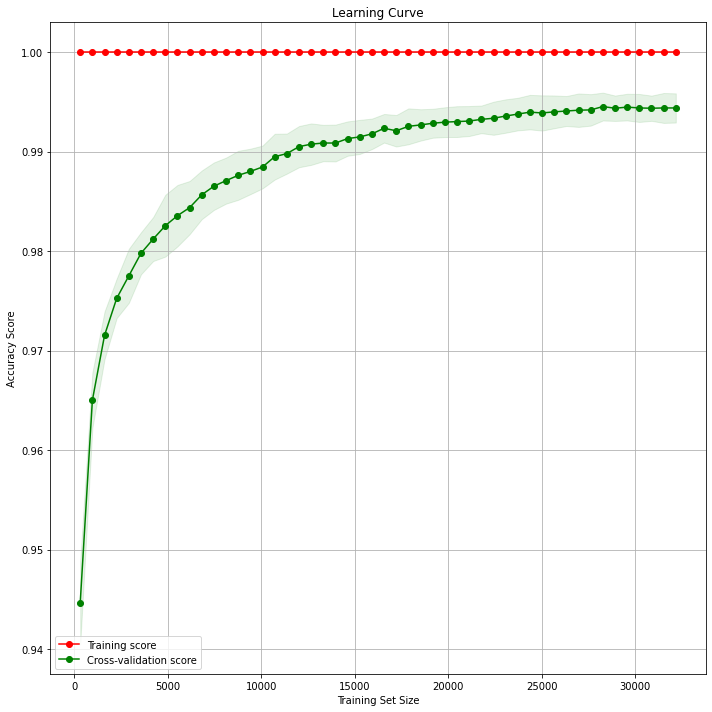

In [79]:
train_sizes, train_scores, test_scores = learning_curve(lr, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plot_learning_curve(train_sizes, train_mean, test_mean, train_std, test_std)

**Insights**
- Geen sprake van overfitting
- weinig loss
- begint stabiel te woden na ongeveer 10000

#### Naive Bayes

fit_prior = True (default):

|                          	| 1 (default) 	| 2     	| 0     	| 0.1   	|
|--------------------------	|-------------	|-------	|-------	|-------	|
| Alpha                    	| 0.936       	| 0.934 	| 0.950 	| 0.946 	|

fit_prior = False:

|                          	| 1 (default) 	| 2     	| 0     	| 0.1   	|
|--------------------------	|-------------	|-------	|-------	|-------	|
| Alpha                    	| 0.937       	| 0.935 	| <mark>0.951</mark> 	| 0.944 	|


fit_prior=False met alpha 0 komt op de hoogste accuracy.

In [84]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(nb, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

/Users/aliozcan/miniforge3/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/aliozcan/miniforge3/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/aliozcan/miniforge3/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/aliozcan/miniforge3/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/aliozcan/miniforge3/lib/python3.9/site-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/Users/aliozcan/miniforge3/lib/python3.9/site-packages/sklearn/naive_bayes.py:55

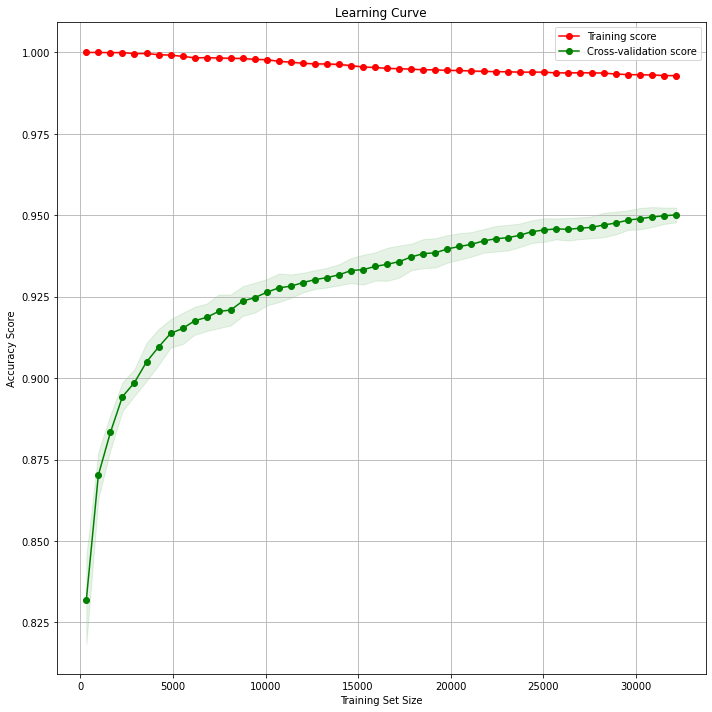

In [85]:
plot_learning_curve(train_sizes, train_mean, test_mean, train_std, test_std)

**Insights**
- training score gaat op z'n tijd ook een beetje achteruit
- Lijkt al iets meer op overfitting

### Conclusie

Voor het voorspellen van real/fake news in deze dataset is het gebruik van Logistic Regression beter dan Naive Bayes. LR komt met 'optimale' parameters op een accuracy score van 9.995 uit. Het is ook niet overtrained of undertrained. Als je C ook gewoon op default zet, krijg je een accuracy van 0.98...

Dit klopt niet met mijn voorspelling. Ik dacht dat Naive Bayes het beter zou doen. Mijn redenering hiervoor is dat Naive Bayes goed kan werken met tekstek, alleen realiseer ik me nu dat we de tekst natuurlijk veranderd hebben ik een matrix met getallen (TF-IDF). Dus mijn redenering klopt niet. 

**Hoe kan ik het verbeteren?**
- GridSearchCV gebruiken om echt de optimale hyperparameters te vinden
- Cross-validation toepassen
- train_test_split op verschillende test_sizes testen

### Bronnen

- https://stats.stackexchange.com/questions/33185/difference-between-naive-bayes-multinomial-naive-bayes
- https://data-flair.training/blogs/advanced-python-project-detecting-fake-news/
- https://medium.com/@HemantSingh0/fake-news-detection-with-python-fcdc60675bf0
- https://www.geeksforgeeks.org/python-lemmatization-with-nltk/